In [4]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [111]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

#varcluster_info=pd.DataFrame(
#{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
#,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
#,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
#})

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

## 1.1 Word Embedding

In [8]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [9]:
## creating a tagged document
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]
tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [10]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-24 10:45:34.346856 Started
2020-01-24 10:51:59.365372 Completed


In [12]:
## Validating the model response for random words 

modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.65 'situation'
    2. 0.65 'system'
    3. 0.63 'constantly'
    4. 0.62 'kind'
    5. 0.61 'way'
    6. 0.60 'habitat'
    7. 0.59 'reservoir'
    8. 0.58 'contexts'
    9. 0.58 'resource'
    10. 0.58 'climatically'
    11. 0.57 'scenario'
    12. 0.57 'continuously'
    13. 0.57 'setting'
    14. 0.57 'potentially'
    15. 0.55 'environments'
    16. 0.55 'object'
    17. 0.55 'community'
    18. 0.55 'circumstance'
    19. 0.55 'obviously'
    20. 0.55 'area'


## 1.2. PCA

In [800]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 60.69031357765198


In [801]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['ISOForestCluster']=1

# 2. ISO Forest 

In [803]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer  =IsolationForest(n_estimators=100, max_samples='auto',behaviour="new", contamination='auto', max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    
    #### Hyper parameter ####
    # eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples -The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
    
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'ISOForestCluster']=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-01-25 01:12:31.464871 Started
******Natural Sciences******
 1    13000
-1      724
dtype: int64
silhouette score: 0.2538843
2020-01-25 01:12:36.399175 Completed

2020-01-25 01:12:36.399242 Started
******Humanities and Social Sciences******
 1    9355
-1     629
dtype: int64
silhouette score: 0.26081184
2020-01-25 01:12:39.273606 Completed

2020-01-25 01:12:39.273691 Started
******Engineering Sciences******
 1    8774
-1     602
dtype: int64
silhouette score: 0.23509346
2020-01-25 01:12:41.780326 Completed

2020-01-25 01:12:41.780408 Started
******Life Sciences******
 1    16992
-1      957
dtype: int64
silhouette score: 0.25303853
2020-01-25 01:12:49.338376 Completed



In [804]:
merged_data['ISOForestCluster'].value_counts()

 1    48121
-1     2912
Name: ISOForestCluster, dtype: int64

In [805]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]

merged_data['CategoryConv']=merged_data.Category.apply(CattoID)

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [ ]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the ISOForestCluster result. outlier data are considering as test data to reevaluate.

X_Training_DS=merged_data[Features][merged_data.ISOForestCluster==1]
y_Training_DS=merged_data[OP_Feature][merged_data.ISOForestCluster==1]

X_Test_DS=merged_data[Features][merged_data.ISOForestCluster!=1]
y_Test_DS=merged_data[OP_Feature][merged_data.ISOForestCluster!=1]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

## 3.1 NaiveBayes

Accuracy Score : 35.957270275876375


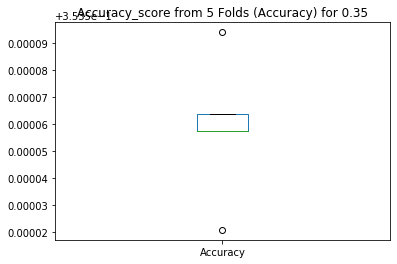

In [798]:
modelNB = MultinomialNB(alpha=1)

#### Hyper parameter ####
# alpha - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

## 3.1  k-nearest neighbors 

In [ ]:
for k in [4,8,16,25,30]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

neighbors: 25 Accuracy Score : 0.8833229620410703


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.88')

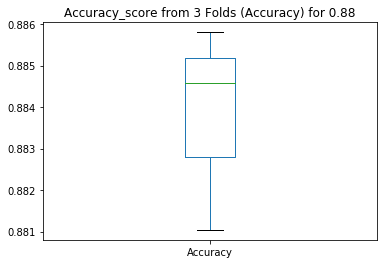

In [806]:
k=25
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)
print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [597]:
for x in [.01]+list(np.linspace(0.1,1,5))+[10]:

    modelSVC = svm.LinearSVC(C=x).fit(X_train, y_train)
    #### Hyper parameter ####
    # C - The strength of the regularization is inversely proportional to C.

    y_pred = modelSVC.predict(X_test)
    print('C -',x,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))


C - 0.01 Accuracy Score : 83.73670886075949
C - 0.1 Accuracy Score : 84.0
C - 0.325 Accuracy Score : 83.96962025316455
C - 0.55 Accuracy Score : 83.95949367088608
C - 0.775 Accuracy Score : 83.9493670886076
C - 1.0 Accuracy Score : 83.96962025316455
C - 10 Accuracy Score : 83.97974683544304


/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 4. Formatting the output categories based on the predict_proba

In [807]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [808]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''



## 5.1. Random manual result evaluvation 

In [809]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['ISOForestCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [810]:
fil_1_2=(NewMergedDSAligned['Category_12_Variance']<=.10) & ((NewMergedDSAligned['Category_1']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))
fil_2_3=(NewMergedDSAligned['Category_23_Variance']<=.10) & ((NewMergedDSAligned['Category_3']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))

NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_1']=NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category']
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

In [811]:
#(NewMergedDSAligned.ISOForestCluster!=0) &

NewMergedDSAligned['ISOForestCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 1    8456
-1     690
Name: ISOForestCluster, dtype: int64

In [812]:
NewMergedDSAligned['ISOForestCluster'].value_counts()

 1    48121
-1     2912
Name: ISOForestCluster, dtype: int64

In [813]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Natural Sciences                  274
Humanities and Social Sciences    162
Life Sciences                     157
Engineering Sciences               97
Name: Category, dtype: int64

In [823]:
cats='Natural Sciences'
lim=540
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
19600,Under the impact of globalisation Bangladesh i...,Natural Sciences,0.479613,0.240730,0.199836,Engineering Sciences,Humanities and Social Sciences,Life Sciences,0.238883,0.040894
35996,Drought events pose a threat to water security...,Natural Sciences,0.439941,0.320346,0.199826,Engineering Sciences,Humanities and Social Sciences,Life Sciences,0.119595,0.120520
44813,More and more innovations are being generated ...,Natural Sciences,0.439924,0.280069,0.199981,Engineering Sciences,Humanities and Social Sciences,Life Sciences,0.159855,0.080088
50856,Approximately 884 million people lack access t...,Natural Sciences,0.439662,0.399851,0.160487,Engineering Sciences,Life Sciences,Natural Sciences,0.039811,0.239364
34892,Background: Studying urban health is of vital ...,Natural Sciences,0.439598,0.320297,0.160249,Life Sciences,Humanities and Social Sciences,Natural Sciences,0.119301,0.160048


In [824]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

['Under the impact of globalisation Bangladesh is rapidly urbanising. By 2020 almost half of the population of Bangladesh will live in urban areas. The metropolitan area of Dhaka will come under intensive pressure to provide land for additional housing considering the restrictions set by flood hazards. The shrinking supply of land suitable for urban development will further increase building densities in informal inner city settlements where the poor are seeking access to urban livelihoods. In the pursuance of livelihoods the urban poor run the risk to sacrifice the functionality of the city by blocking vehicular access, encroaching upon land reserved for public infrastructure, threatening public health and settling on flood-prone land. The statutory planning system is, however, ill equipped to establish an appropriate balance between the vital interests of individual households and enterprises on the one hand and public welfare on the other. The proposed project is based on the propos

In [816]:
#NewMergedDSAligned.to_csv(Path+'WEPCADBScanFindingsKMeans.csv', index=False)

## 5.2. Each category TF/IDF based result evaluvation 

In [817]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.ISOForestCluster!=1) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [818]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [819]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [820]:
sizes=len(input_data.CategoryCollc.unique())
#plt.subplots(figsize=(8,150)) 
j=1

for i,bucket in input_data.groupby(['CategoryCollc']):
    
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(bucket))
    
    if(len(bucket)>1):
        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[['Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        #print(varcat.category.value_counts())
        #print(varcat.apply(lambda x: x.Variable +' - NA' if(pd.isnull(x.category)) else x.Variable +'  - '+x.category , axis=1))
        print('Rare words',list(varcat[varcat.category!='General'].Variable))
    
    else:
        print(bucket.Translates.tolist())
    
    print('----------------------------------------------------------')
    
    #print(features_df.sum().sort_values(ascending=False),'\n')
    
    #vectorizer.get_feature_names()
 
    #plt.subplot(1,sizes,j)
    #features_df.sum().sort_values(ascending=False).plot(kind='bar',color='green')
    #plt.title(i.split(',')[0]+' -'+','.join(i.split(',')[1:]))
    #plt.xticks(rotation=60)
    
    #j=j+1
    #plt.tight_layout()
    

Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 21
Rare words ['research', 'context', 'building', 'architectural', 'video', 'urban', 'argument', 'spatial', 'planning', 'approach', 'architecture', 'system', 'method', 'study', 'process', 'different']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 18
Rare words ['model', 'research', 'approach', 'study', 'representation', 'change', 'planning', 'process', 'develop', 'communication', 'method', 'spatial', 'use', 'question', 'system', 'cognitive']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences', 'Life Sciences'] : Number of Documents - 1
['Visualizations are perceived by humans like any other type of images, thus it is crucial to select appropriate display parameters for faithfully transporting the under

Rare words ['nirs', 'olg', 'sample', 'segmentation', 'organ', 'lung', 'amplification', 'crs', 'perfusion', 'signal', 'shall', 'technique', 'method', 'level', 'approach']
----------------------------------------------------------
Engineering Sciences - ['Life Sciences', 'Engineering Sciences'] : Number of Documents - 12
Rare words ['image', 'system', 'visualization', 'method', 'process', 'surgical', 'allow', 'model', 'protein', 'develop', 'cell', 'electrode', 'culture', 'impedance', 'co']
----------------------------------------------------------
Engineering Sciences - ['Life Sciences', 'Engineering Sciences', 'Humanities and Social Sciences'] : Number of Documents - 1
['Rapid progress in neurotechnology and machine learning enables closed-loop interaction with the brain and unlocks the door to a new class of clinical applications, e.g. for stroke patients. This group exhibits strong performance fluctuations in repeated trials of hand motor training. Utilizing single-trial data analysis

Rare words ['biomolecular', 'material', 'cell', 'differentiation', 'actuation', 'tissue', 'structure', 'thz', 'free', 'plant', 'hierarchical', 'surface', 'specific', 'phase', 'development', 'impact', 'technology', 'pattern']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences'] : Number of Documents - 2
Rare words ['symmetry', 'earth', 'exascale', 'mantle', 'flow', 'new', 'solution', 'scale', 'turbulent', 'law', 'correlation', 'couette', 'validate', 'pdf', 'present', 'shear', 'transpiration', 'parameter']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences', 'Engineering Sciences'] : Number of Documents - 22
Rare words ['structure', 'property', 'allow', 'photonic', 'order', 'model', 'technique', 'signal', 'system', 'algorithm', 'electronic', 'material', 'thz', 'optical', 'particle', 'high']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences

Rare words ['model', 'research', 'risk', 'problem', 'effect', 'decision', 'approach', 'study', 'method', 'process', 'behavior', 'high', 'develop', 'level', 'firm']
----------------------------------------------------------
Humanities and Social Sciences - ['Engineering Sciences', 'Humanities and Social Sciences'] : Number of Documents - 47
Rare words ['research', 'effect', 'study', 'model', 'market', 'task', 'social', 'strategy', 'student', 'process', 'individual', 'economic', 'group']
----------------------------------------------------------
Humanities and Social Sciences - ['Engineering Sciences', 'Humanities and Social Sciences', 'Life Sciences'] : Number of Documents - 4
Rare words ['sectoral', 'tendency', 'capital', 'productivity', 'conflict', 'model', 'behavior', 'country', 'control', 'self', 'research', 'flow', 'financial', 'international', 'market', 'propose', 'development']
----------------------------------------------------------
Humanities and Social Sciences - ['Engineeri

Rare words ['effect', 'study', 'network', 'different', 'disorder', 'research', 'relate', 'child', 'measure', 'task', 'brain', 'stress', 'control', 'monitoring', 'change', 'response', 'individual', 'cardiac']
----------------------------------------------------------
Humanities and Social Sciences - ['Natural Sciences'] : Number of Documents - 1
['The project aims at investigating the morphological boundary in binary, semantically nonopaque German compounds and particle verbs using methods of acoustic and articulatory phonetics. The general question is whether this morphological boundary maps onto the prosodic boundary between two phonological words; in this case, the phonetic marking of the word¿s edges should be same as at a syntactic boundary. In order to answer this question, compound-internal edges are compared with those at syntactic phrase boundaries under identical conditions of segmental and rhythmical structure. The central hypothesis of the project is that compound-internal e

Rare words ['system', 'model', 'effect', 'cell', 'field', 'method', 'patient', 'increase', 'approach', 'develop', 'clinical', 'development', 'research', 'tissue', 'test', 'heart']
----------------------------------------------------------
Life Sciences - ['Engineering Sciences', 'Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 3
Rare words ['credit', 'health', 'use', 'service', 'model', 'land', 'scenario', 'biodiversity', 'priority', 'identify', 'agricultural', 'weather', 'risk', 'microfinance', 'study', 'farming', 'conflict', 'default', 'person']
----------------------------------------------------------
Life Sciences - ['Engineering Sciences', 'Life Sciences', 'Natural Sciences'] : Number of Documents - 3
Rare words ['tissue', 'fish', 'light', 'channel', 'measurement', 'cell', 'sensitive', 'epithelial', 'swarm', 'energy', 'composite', 'carrier', 'pre', 'movement', 'membrane', 'purpose', 'group', 'plasma', 'optogenetic']
--------------------------------------

Rare words ['earth', 'protein', 'field', 'dynamic', 'nonlinear', 'light', 'snow', 'molecular', 'microwave', 'scale', 'process', 'active', 'high', 'system', 'vegetation', 'new', 'early', 'interaction', 'research']
----------------------------------------------------------
Life Sciences - ['Natural Sciences', 'Engineering Sciences'] : Number of Documents - 7
Rare words ['soil', 'physics', 'quantum', 'cui', 'spatial', 'new', 'surface', 'rydberg', 'property', 'effect', 'research', 'material', 'gas', 'structure', 'system', 'different', 'state', 'solid', 'study', 'field']
----------------------------------------------------------
Life Sciences - ['Natural Sciences', 'Engineering Sciences', 'Life Sciences'] : Number of Documents - 3
Rare words ['colloid', 'research', 'system', 'transport', 'multivalent', 'theoretical', 'interaction', 'microgel', 'functionality', 'development', 'contaminant', 'material', 'molecular', 'process', 'new', 'experimental', 'scale', 'flow', 'medium']
----------------

Rare words ['reaction', 'particle', 'ligand', 'microgel', 'intermediate', 'fuel', 'mps', 'interaction', 'cell', 'magnetic', 'temperature', 'system', 'team', 'composite', 'app', 'study', 'display', 'development']
----------------------------------------------------------
Natural Sciences - ['Humanities and Social Sciences'] : Number of Documents - 10
Rare words ['process', 'use', 'human', 'development', 'place', 'spatial', 'social', 'sand', 'research', 'science', 'method', 'chapter', 'develop', 'orientation', 'earth', 'system', 'navigation']
----------------------------------------------------------
Natural Sciences - ['Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 12
Rare words ['local', 'research', 'urban', 'development', 'social', 'global', 'different', 'network', 'question', 'economic', 'system', 'study', 'process', 'change', 'form', 'spatial', 'housing', 'quality']
----------------------------------------------------------
Natural Sciences - ['Hum

Rare words ['research', 'garlic', 'aptamer', 'flavor', 'human', 'food', 'test', 'perception', 'odor', 'process', 'development', 'metabolite', 'substance', 'card', 'physiological', 'milk', 'individual']
----------------------------------------------------------
Natural Sciences - ['Life Sciences', 'Humanities and Social Sciences', 'Natural Sciences'] : Number of Documents - 1
['Background: Studying urban health is of vital importance, because the majority of the world¿s population is living in urban areas. Moreover, health and environmental inequalities are significant in inner city neighbourhoods. However, most existing studies do not address urban health with the multidisciplinary and integrative approaches that are necessary to capture the complexity of socio-ecological environments in cities. Furthermore, spatial and spatio-temporal analyses of health related questions in urban settings are lacking. In order to advance science and inform public health policies, research needs to del

In [821]:
cats='Engineering Sciences'
cat1='Humanities and Social Sciences'
cat2='Life Sciences'
cat3=''  #'Natural Sciences'
 
lim=200
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
38967,The use of Knowledge Organization Systems (KOS...,Engineering Sciences,0.600063,0.320265,0.079673,Humanities and Social Sciences,Life Sciences,,0.279798,0.240592
24236,Although computational models of visual attent...,Engineering Sciences,0.599894,0.279638,0.120468,Humanities and Social Sciences,Life Sciences,,0.320256,0.159170
48194,"Research involving anatomy-related, objectivyi...",Engineering Sciences,0.599664,0.320076,0.080260,Humanities and Social Sciences,Life Sciences,,0.279588,0.239815
42526,Similarity search is becoming an ever more imp...,Engineering Sciences,0.480260,0.479879,0.039861,Humanities and Social Sciences,Life Sciences,,0.000381,0.440017
19868,Brain-Computer Interfaces (BCIs) allow intenti...,Engineering Sciences,0.440291,0.439901,0.119808,Humanities and Social Sciences,Life Sciences,,0.000390,0.320093


In [822]:
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()

['The use of Knowledge Organization Systems (KOS) such as thesauri or ontologies in the medical field has shown great value to tackle semantic interoperability issues. In many cases, KOS are used to annotate real world objects such as electronic health records (EHR), case report forms (CRF) of clinical trials, genes or publications in order to make their semantics explicit for applications and tools. The dynamic nature of medical knowledge forces knowledge engineers to continuously revise the content of either KOSs or underlying data. These changes may directly impact the annotations associated with changed concepts or changed data. Hence, new KOS versions can invalidate previous annotations. Similarly, if the content of an annotated document is modified the existing annotation may become irrelevant. As a result, many annotations can lose their relevance and value thus impeding the intended use and exploitation of annotated data. The ELISA (Evolution of Semantic Annotations) project th

# Visualization

In [825]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['ISOForestCluster']!=1)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

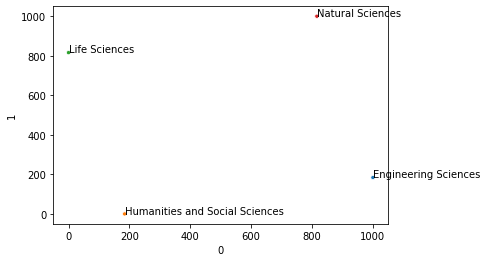

In [837]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

coords = TSNE(n_components=2,perplexity=4.2, random_state=18, metric='precomputed').fit_transform(sym_dist)
#coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [827]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.099927,0.442820,0.383199
Humanities and Social Sciences,0.099927,0.000000,0.612463,0.868030
Life Sciences,0.442820,0.612463,0.000000,0.611571
Natural Sciences,0.383199,0.868030,0.611571,0.000000


In [838]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,0.000000,815.954590,-224.362500,224.362500,681.337090,950.572090
1,Natural Sciences,171.5500,815.876831,1000.000061,644.326831,987.426831,897.070061,1102.930061
2,Humanities and Social Sciences,124.8000,184.123108,0.000000,59.323108,308.923108,-74.880000,74.880000
3,Engineering Sciences,117.2000,1000.000061,184.046143,882.800061,1117.200061,113.726143,254.366143


In [839]:
pca.shape

(51033, 20)

In [840]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-01-25 01:27:17.914175 Started for Engineering Sciences
2020-01-25 01:27:39.844901 Completed for Engineering Sciences
2020-01-25 01:27:39.847108 Started for Humanities and Social Sciences
2020-01-25 01:28:03.659064 Completed for Humanities and Social Sciences
2020-01-25 01:28:03.659861 Started for Life Sciences
2020-01-25 01:28:55.933148 Completed for Life Sciences
2020-01-25 01:28:55.934513 Started for Natural Sciences
2020-01-25 01:30:59.031162 Completed for Natural Sciences


In [841]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


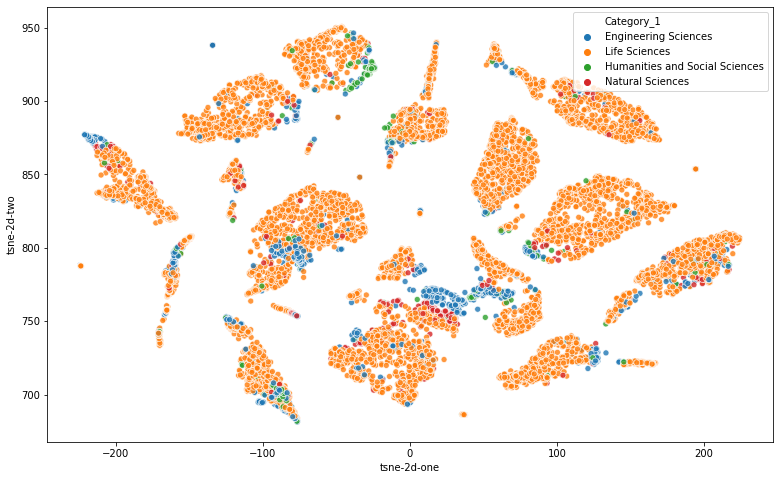

In [842]:
cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

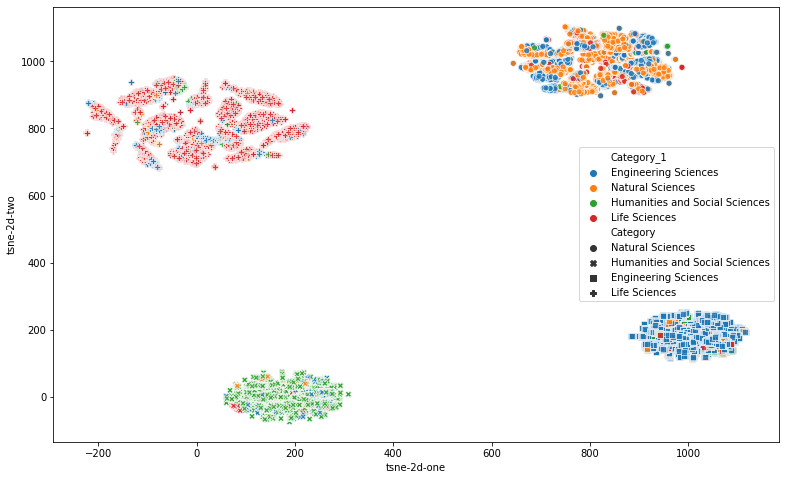

In [843]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [844]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.ISOForestCluster==1)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','ISOForestCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['ISOForestCluster']!=1),'interdiscipilinary']=True

In [845]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [846]:
Report_extrat.to_csv(Path+'Report_WEPCAISOForestFindingsKMeans.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCAISOForestFindingsKMeans.csv', index=False)